<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Orthogonal Random Forest: Use Cases and Examples

Orthogonal Random Forest (ORF) combines orthogonalization,
a technique that effectively removes the confounding effect in two-stage estimation,
with generalized random forests, a flexible method for estimating treatment effect heterogeneity. Due to the orthogonalization aspect of this method, the ORF performs especially well in the presence of high-dimensional confounders. For more details, see [this paper](https://arxiv.org/abs/1806.03467).

The EconML SDK implements the following OrthoForest variants:

* ContinuousTreatmentOrthoForest: suitable for continuous treatments

* DiscreteTreatmentOrthoForest: suitable for discrete treatments

In this notebook, we show the performance of the ORF on synthetic data.

**Notebook contents:**

1. Example usage with continuous treatment synthetic data

2. Example usage with binary treatment synthetic data

3. Example usage with multiple discrete treatment synthetic data

4. Example usage with real continuous treatment observational data

In [1]:
import econml

In [2]:
# Main imports
from econml.ortho_forest import ContinuousTreatmentOrthoForest, WeightedModelWrapper, DiscreteTreatmentOrthoForest

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
#from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Example Usage with Continuous Treatment Synthetic Data

### 1.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [3]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [4]:
# DGP constants
np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
# Treatment support 
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
# The following parameters are set according to theory
subsample_power = 0.88
subsample_ratio = ((n/np.log(n_w))**(subsample_power)) / n
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 1.2. Train Estimator

**Note:** The models in the final stage of the estimation (``model_T_final``, ``model_Y_final``) need to support sample weighting. 

If the models of choice do not support sample weights (e.g. ``sklearn.linear_model.LassoCV``), the ``econml`` packages provides a convenient wrapper for these models ``WeightedModelWrapper`` in order to allow sample weights. 

If the model of choice is a linear (regression) model such as Lasso, you should set ``sample_type="weighted"``. Otherwise, set ``sample_type="sampled"``.

In [5]:
est = ContinuousTreatmentOrthoForest(
    n_trees=200, min_leaf_size=5,
    max_splits=50, subsample_ratio=2*subsample_ratio, bootstrap=False, 
    model_T=Lasso(alpha=lambda_reg), 
    model_Y=Lasso(alpha=lambda_reg), 
    model_T_final=WeightedModelWrapper(Lasso(alpha=lambda_reg), sample_type="weighted"), 
    model_Y_final=WeightedModelWrapper(Lasso(alpha=lambda_reg), sample_type="weighted"),
    random_state=123)

In [6]:
est.fit(Y, T, X, W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished


In [7]:
treatment_effects = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


### 1.3. Performance Visualization

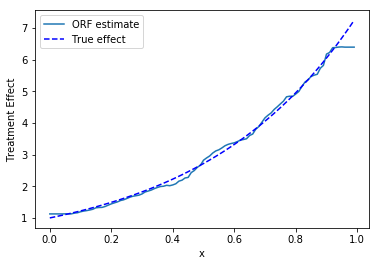

In [8]:
y = treatment_effects[:, 0]
plt.plot(X_test, y, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

## 2. Example Usage with Binary Treatment Synthetic Data

### 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [49]:
# DGP constants
np.random.seed(1234)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
# Treatment support 
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
# The following parameters are set according to theory
subsample_power = 0.88
subsample_ratio = ((n/np.log(n_w))**(subsample_power)) / n
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 2.2. Train Estimator 

In [50]:
est = DiscreteTreatmentOrthoForest(
    n_trees=200, min_leaf_size=10,
    max_splits=30, subsample_ratio=2*subsample_ratio, bootstrap=False,
    propensity_model = LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1'),
    model_Y = Lasso(alpha=lambda_reg),
    propensity_model_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1'), 
    model_Y_final=WeightedModelWrapper(Lasso(alpha=lambda_reg), sample_type="weighted")
)

In [51]:
est.fit(Y, T, X, W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   37.6s finished


In [52]:
treatment_effects = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


### 2.3. Performance Visualization

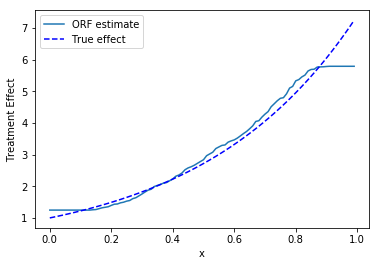

In [53]:
y = treatment_effects[:, 0]
plt.plot(X_test, y, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

## 3. Example Usage with Multiple Treatment Synthetic Data

### 3.1 DGP 
We use the following DGP:

\begin{align}
Y = & \sum_{t=1}^{n_{\text{treatments}}} 1\{T=t\}\cdot \theta_{T}(X) + \langle W, \gamma\rangle + \epsilon, \; \epsilon \sim \text{Unif}(-1, 1), \\
\text{Pr}[T=t \mid W] \propto & \exp\{\langle W, \beta_t \rangle\}, \;\;\;\; \forall t\in \{0, 1, \ldots, n_{\text{treatments}}\} 
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta_t, \gamma$ are sparse.

For this particular example DGP we used $n_{\text{treatments}}=3$ and 
\begin{align}
\theta_1(x) = & \exp( 2 x_1 ),\\
\theta_2(x) = &  3 \cdot \sigma(100\cdot (x_1 - .5)),\\
\theta_3(x) = & -2 \cdot \sigma(100\cdot (x_1 - .25)),
\end{align}
where $\sigma$ is the sigmoid function.

In [14]:
def get_test_train_data(n, n_w, support_size, n_x, te_func, n_treatments):
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
    # Treatment support 
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=(support_size, n_treatments))
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    # Heterogeneous treatment effects
    TE = np.array([te_func(x_i, n_treatments) for x_i in X])
    log_odds = np.dot(W[:, support_T], coefs_T)
    T_sigmoid = np.exp(log_odds)
    T_sigmoid = T_sigmoid/np.sum(T_sigmoid, axis=1, keepdims=True)
    T = np.array([np.random.choice(n_treatments, p=p) for p in T_sigmoid])
    TE = np.concatenate((np.zeros((n,1)), TE), axis=1)
    Y = TE[np.arange(n), T] + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

    return (Y, T, X, W), (X_test, np.array([te_func(x, n_treatments) for x in X_test]))

In [15]:
import scipy.special
def te_func(x, n_treatments):
    return [np.exp(2*x[0]), 3*scipy.special.expit(100*(x[0] - .5)) - 1, -2*scipy.special.expit(100*(x[0] - .25))]

np.random.seed(123)
(Y, T, X, W), (X_test, te_test) = get_test_train_data(1000, 3, 3, 1, te_func, 4)

### 3.2 Train Estimator

In [16]:
est = DiscreteTreatmentOrthoForest(n_trees=500,
                                   propensity_model = LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1'),
                                   model_Y = WeightedModelWrapper(Lasso(alpha=lambda_reg)))

In [17]:
est.fit(Y, T, X, W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


In [18]:
treatment_effects = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.1min finished


### 3.3 Performance Visualization

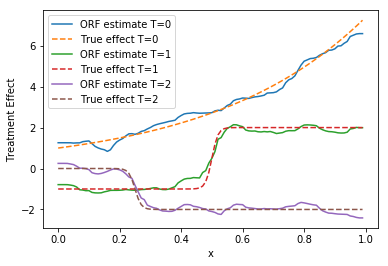

In [19]:
y = treatment_effects
for it in range(y.shape[1]):
    plt.plot(X_test, y[:, it], label='ORF estimate T={}'.format(it))
    plt.plot(X_test[:, 0], te_test[:, it], '--', label='True effect T={}'.format(it))
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

## 4. Example usage with real continuous treatment observational data

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

The dataset is comprised of a large number of covariates $W$, but researchers might only be interested in learning the elasticity of demand as a function of a few variables $x$ such
as income or education. 

We applied the `ContinuousTreatmentOrthoForest` to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

### 4.1. Data

In [20]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [21]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [22]:
# Prepare data
Y = oj_data['logmove'].values
T = np.log(oj_data["price"]).values
scaler = StandardScaler()
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store']]].values)
W2 = pd.get_dummies(oj_data[['brand']]).values
W = np.concatenate([W1, W2], axis=1)
X = oj_data[['INCOME']].values

### 4.2. Train Estimator

In [23]:
# Define some parameters
n_trees = 500
min_leaf_size = 50
max_splits = 20
subsample_ratio = 0.02
bootstrap = False

In [24]:
est = ContinuousTreatmentOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_splits=max_splits, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.5), model_Y=Lasso(alpha=0.5), 
        model_T_final=WeightedModelWrapper(LassoCV(), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(), sample_type="weighted")
       )

In [25]:
min_income = 10.4 
max_income = 10.9
delta = (max_income - min_income) / 50
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [26]:
est.fit(Y, T, X, W)
te_pred = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  3.4min finished


### 4.3. Performance Visualization

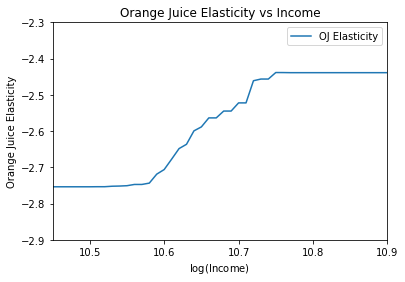

In [27]:
# Plot Oranje Juice elasticity as a function of income
plt.plot(np.ndarray.flatten(X_test), te_pred[:, 0], label="OJ Elasticity")
plt.xlabel(r'$\log$(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.xlim(10.45, 10.9)
plt.ylim(-2.9, -2.3)
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### 4.4 Bootstrap Confidence Intervals

In [28]:
from econml.bootstrap import BootstrapEstimator
boot_est = BootstrapEstimator(ContinuousTreatmentOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_splits=max_splits, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.5), model_Y=Lasso(alpha=0.5), 
        model_T_final=WeightedModelWrapper(LassoCV(), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(), sample_type="weighted")
       ), n_bootstrap_samples=10)

In [29]:
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.6s finished
[

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  3.5min finished


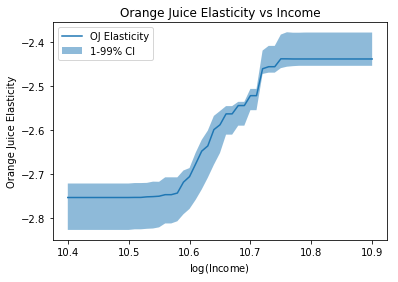

In [30]:
plt.plot(np.ndarray.flatten(X_test), te_pred[:, 0], label="OJ Elasticity")
plt.fill_between(np.ndarray.flatten(X_test), 
                 te_pred_interval[0][:, 0], 
                 te_pred_interval[1][:, 0], alpha=.5, label="1-99% CI")
plt.xlabel(r'$\log$(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()